<a href="https://colab.research.google.com/github/parth57/Self_Drive/blob/master/Self_Driving_Car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/parth57/Self_Drive

Cloning into 'Self_Drive'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 8678 (delta 0), reused 0 (delta 0), pack-reused 8674
Receiving objects: 100% (8678/8678), 116.27 MiB | 18.52 MiB/s, done.
Checking out files: 100% (8692/8692), done.


In [2]:
!ls Self_Drive

driving_log.csv  IMG


In [3]:
!pip3 install imgaug

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import keras
from keras.layers import Convolution2D,MaxPooling2D,Dropout,Flatten,Dense
from keras.optimizers import Adam
from keras.models import Sequential
from imgaug import augmenters as iaa
from sklearn.utils import shuffle
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import random
import ntpath
from keras.preprocessing.image import (ImageDataGenerator, Iterator,
                                       array_to_img, img_to_array, load_img)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
datadir='Self_Drive'
columns=['center','left','right','steering','throttle','reverse','speed']
data=pd.read_csv(os.path.join(datadir,'driving_log.csv'),names=columns)
pd.set_option('display.max_colwidth',None)
data.head()

center  ...     speed
0  C:\Users\HP\Desktop\Data\IMG\center_2020_07_30_17_51_19_604.jpg  ...  0.000078
1  C:\Users\HP\Desktop\Data\IMG\center_2020_07_30_17_51_19_706.jpg  ...  0.000084
2  C:\Users\HP\Desktop\Data\IMG\center_2020_07_30_17_51_19_807.jpg  ...  0.000082
3  C:\Users\HP\Desktop\Data\IMG\center_2020_07_30_17_51_19_910.jpg  ...  0.000078
4  C:\Users\HP\Desktop\Data\IMG\center_2020_07_30_17_51_20_011.jpg  ...  0.000079

[5 rows x 7 columns]

In [6]:
def path_leaf(path):
  head,tail=ntpath.split(path)
  return tail
data['center']=data['center'].apply(path_leaf)
data['left']=data['left'].apply(path_leaf)
data['right']=data['right'].apply(path_leaf)
data.head()  


center  ...     speed
0  center_2020_07_30_17_51_19_604.jpg  ...  0.000078
1  center_2020_07_30_17_51_19_706.jpg  ...  0.000084
2  center_2020_07_30_17_51_19_807.jpg  ...  0.000082
3  center_2020_07_30_17_51_19_910.jpg  ...  0.000078
4  center_2020_07_30_17_51_20_011.jpg  ...  0.000079

[5 rows x 7 columns]

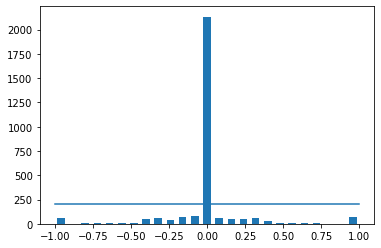

In [7]:
num_bins=25
samples_per_bin=200
hist,bins=np.histogram(data['steering'],num_bins)
center=(bins[:-1]+bins[1:])*.5
plt.bar(center,hist,width=.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))


removed: 1933
remaining: 964


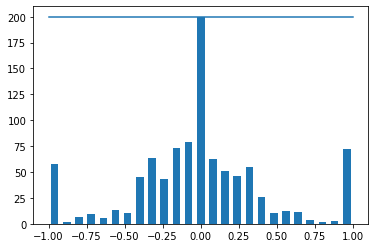

In [8]:

remove_list=[]
for j in range(num_bins):
  list_=[]
  for i in range(len(data['steering'])):
    if data['steering'][i]>=bins[j] and data['steering'][i]<=bins[j+1]:
      list_.append(i)
  list_=shuffle(list_)
  list_=list_[samples_per_bin:]
  remove_list.extend(list_)
print('removed:',len(remove_list))
data.drop(data.index[remove_list],inplace=True)
print('remaining:',len(data))

hist,_=np.histogram(data['steering'],(num_bins))
plt.bar(center,hist,width=.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))


In [9]:
"""

print(data.iloc[0])
def load_img_steering(datadir,df):
  image_path=[]
  steering=[]
  for i in range(len(data)):
    indexed_data=data.iloc[i]
    center,left,right=indexed_data[0],indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(indexed_data[3])
  image_paths=np.asarray(image_path)
  steerings=np.asarray(steering)
  return image_paths,steerings
image_paths,steerings=load_img_steering(datadir + '/IMG',data) """


"\n\nprint(data.iloc[0])\ndef load_img_steering(datadir,df):\n  image_path=[]\n  steering=[]\n  for i in range(len(data)):\n    indexed_data=data.iloc[i]\n    center,left,right=indexed_data[0],indexed_data[1],indexed_data[2]\n    image_path.append(os.path.join(datadir,center.strip()))\n    steering.append(indexed_data[3])\n  image_paths=np.asarray(image_path)\n  steerings=np.asarray(steering)\n  return image_paths,steerings\nimage_paths,steerings=load_img_steering(datadir + '/IMG',data) "

In [10]:

def load_img_steering(datadir,df):
  image_path=[]
  steering=[]
  for i in range(len(data)):
    indexed_data=data.iloc[i]
    center,left,right=indexed_data[0],indexed_data[1],indexed_data[2]
    #image_path.append(os.path.join(datadir,center.strip()))
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(indexed_data[3])
  image_paths=np.asarray(image_path)
  steerings=np.asarray(steering)
  return image_paths,steerings
image_paths,steerings=load_img_steering(datadir+'/IMG',data)

#indexed_data=data.iloc[0]
#indexed_data[0].split('\\')[6]

In [11]:
 X_train,X_valid,y_train,y_valid=train_test_split(image_paths,steerings,test_size=.2,random_state=101)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train),len(X_valid)))

Training Samples: 771
Valid Samples: 193


In [12]:
data.iloc[0]

center      center_2020_07_30_17_51_20_428.jpg
left          left_2020_07_30_17_51_20_428.jpg
right        right_2020_07_30_17_51_20_428.jpg
steering                             -0.154184
throttle                               0.10602
reverse                                      0
speed                                0.0212691
Name: 8, dtype: object

In [13]:
X_train[0]

'Self_Drive/IMG/center_2020_07_30_17_56_21_601.jpg'

Text(0.5, 1.0, 'Validation Set')

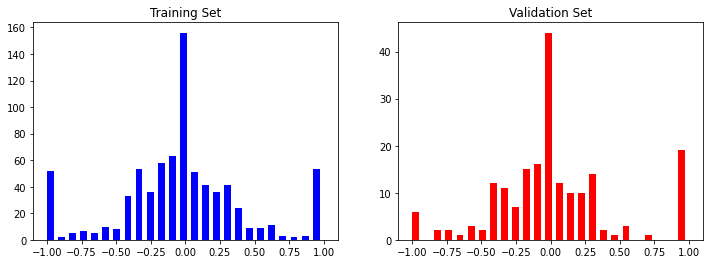

In [14]:
fig,axes=plt.subplots(1,2,figsize=(12,4))
axes[0].hist(y_train,bins=num_bins,width=.05,color='blue')
axes[0].set_title('Training Set')
axes[1].hist(y_valid,bins=num_bins,width=.05,color='red')
axes[1].set_title('Validation Set')


In [15]:
def zoom(image):
  zoom=iaa.Affine(scale=(1,1.3))
  image=zoom.augment_image(image)
  return image



Text(0.5, 1.0, 'Zoomed_Image')

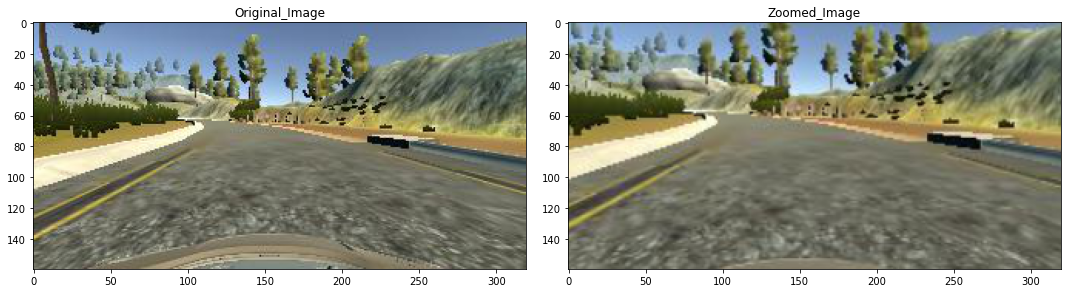

In [16]:
image=image_paths[np.random.randint(1,964)]
original_image=mpimg.imread(image)
zoomed_image=zoom(original_image)
fig,axes=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original_Image')
axes[1].imshow(zoomed_image)
axes[1].set_title('Zoomed_Image')



In [17]:
def pan(image):
  pan=iaa.Affine(translate_percent={'x':(-.1,.1),'y':(-.1,.1)})
  image=pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned_Image')

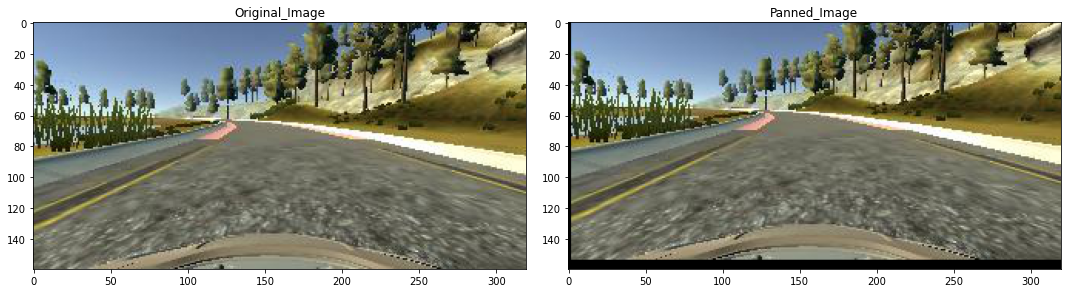

In [18]:
image=image_paths[100]
original_image=mpimg.imread(image)
panned_image=pan(original_image)
fig,axes=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original_Image')
axes[1].imshow(panned_image)
axes[1].set_title('Panned_Image')



In [19]:
 def img_random_brightness(image):
   brightness=iaa.Multiply((.2,1.2))
   image=brightness.augment_image(image)
   return image


Text(0.5, 1.0, 'Brightness_altered_image')

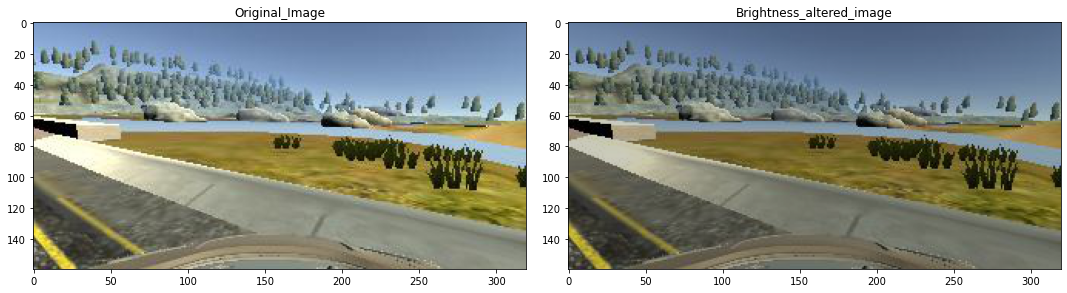

In [20]:
image=image_paths[np.random.randint(1,964)]
original_image=mpimg.imread(image)
brightened_image=img_random_brightness(original_image)
fig,axes=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original_Image')
axes[1].imshow(brightened_image)
axes[1].set_title('Brightness_altered_image')



In [21]:
def img_random_flip(image,steering_angle):
  image=cv2.flip(image,1)
  steering_angle=-steering_angle
  return image,steering_angle

Text(0.5, 1.0, 'Flipped_Image- Steering_Angle:-0.0')

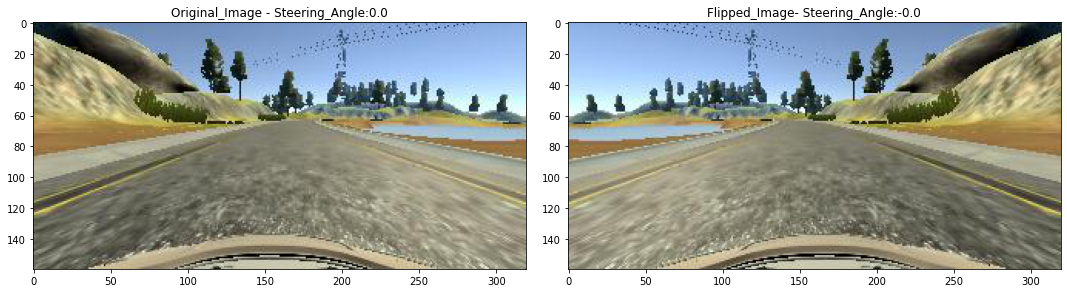

In [22]:
random_index=np.random.randint(1,964)
image=image_paths[random_index]
steering_angle=steerings[random_index]

original_image=mpimg.imread(image)
flipped_image,flipped_steering_angle=img_random_flip(original_image,steering_angle)

fig,axes=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original_Image - '+ 'Steering_Angle:' +str(steering_angle))
axes[1].imshow(flipped_image)
axes[1].set_title("Flipped_Image- "+'Steering_Angle:' +str(flipped_steering_angle))



In [23]:
def random_augment(image,steering_angle):
  image=mpimg.imread(image)
  if np.random.rand()<.5:
    image=pan(image)
  if np.random.rand()<.5:
    image=zoom(image)
  if np.random.rand()<.5:
    image=img_random_brightness(image)
  if np.random.rand()<.5:
    image,steering_angle=img_random_flip(image,steering_angle)
  return image,steering_angle
  

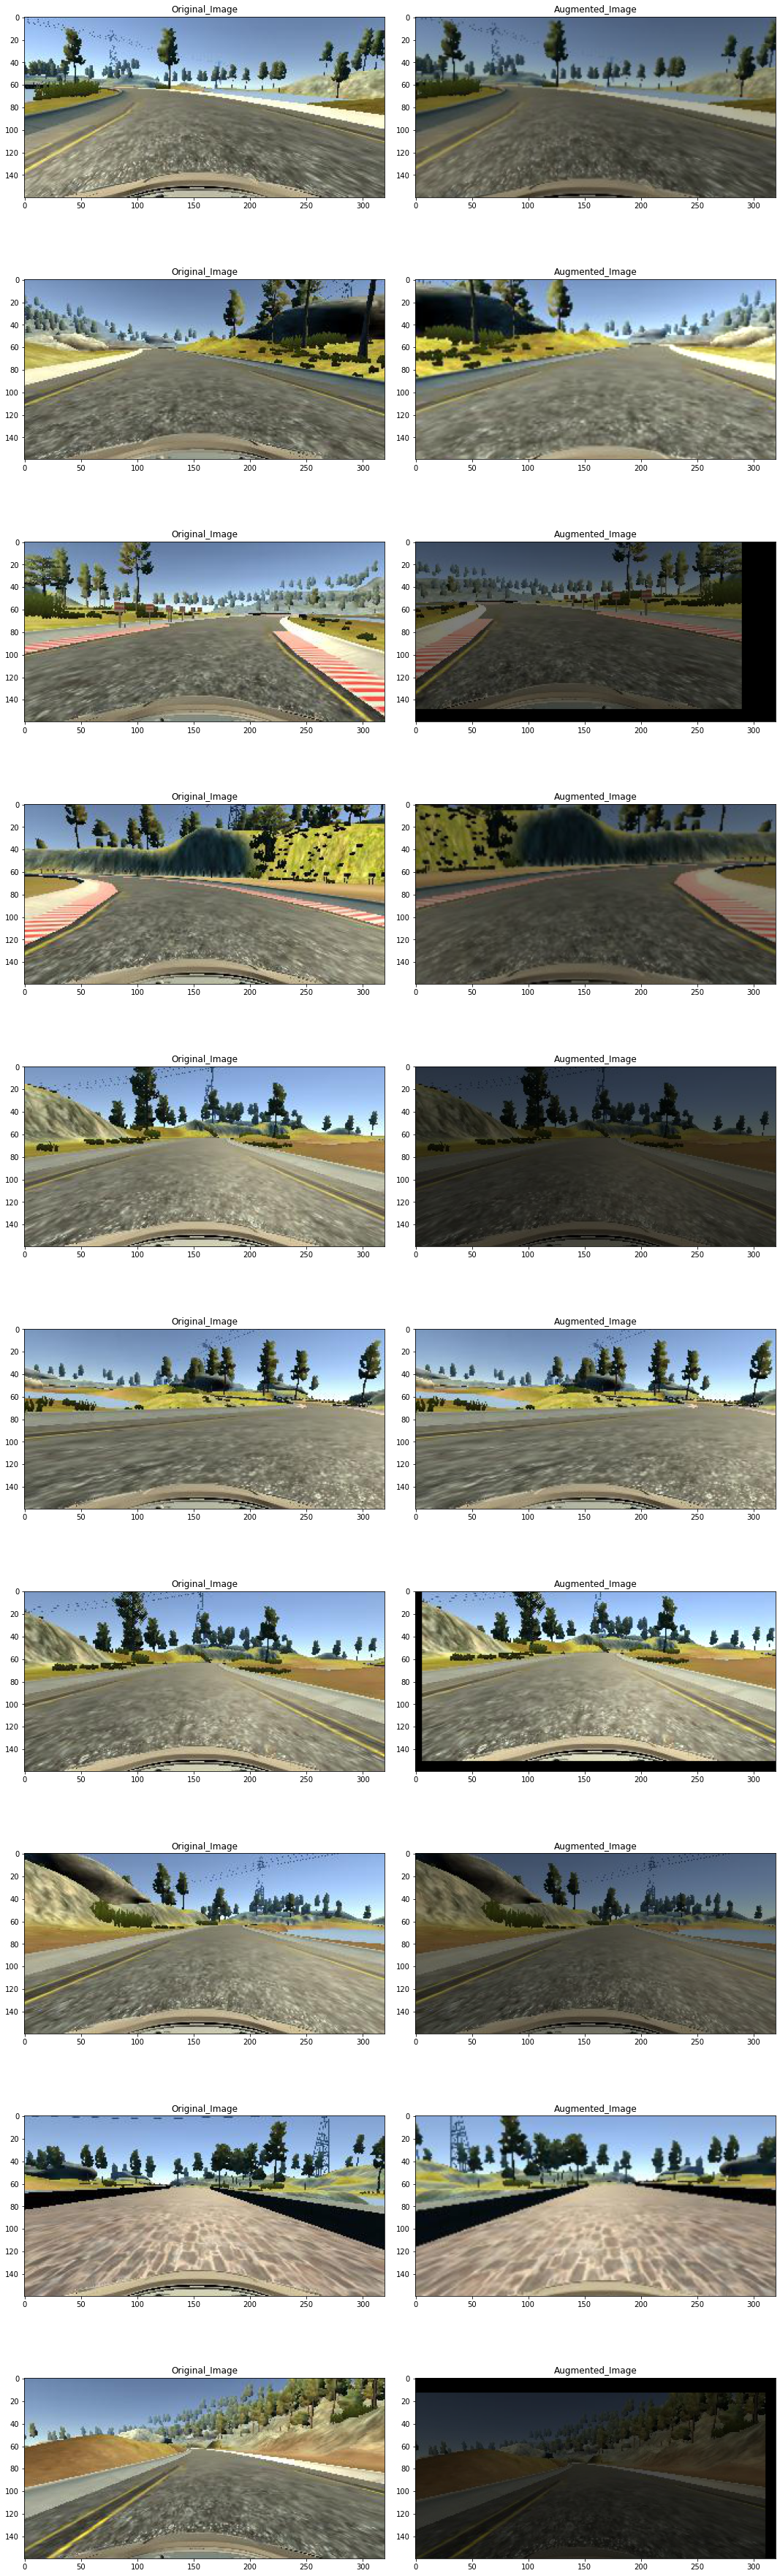

In [24]:
ncol=2
nrow=10
fig,axes=plt.subplots(nrow,ncol,figsize=(15,50))
fig.tight_layout()

for i in range(10):
  randnum=random.randint(0,len(image_paths)-1)
  random_image=image_paths[randnum]
  random_steering=steerings[randnum]
  original_image=mpimg.imread(random_image)
  augmented_image,steering=random_augment(random_image,random_steering)
  axes[i][0].imshow(original_image)
  axes[i][0].set_title('Original_Image')
  axes[i][1].imshow(augmented_image)
  axes[i][1].set_title('Augmented_Image')

In [25]:
def img_preprocessing(img):
  img=mpimg.imread(img)
  img=img[60:135,:,:]
  img=cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  img=cv2.GaussianBlur(img,(3,3),0)
  img=cv2.resize(img,(200,66))
  img=img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

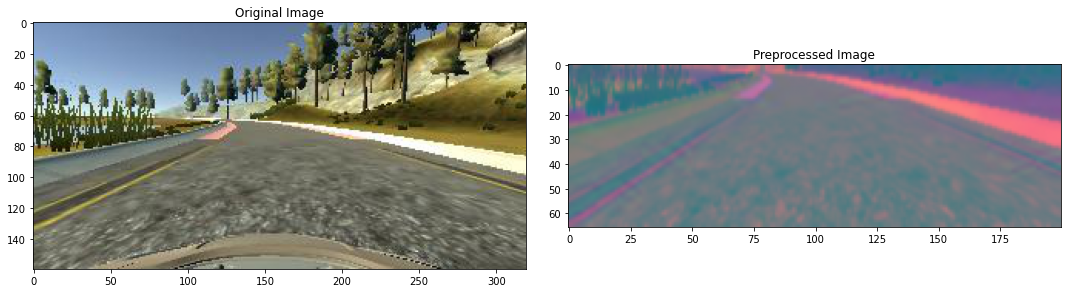

In [26]:
image=image_paths[100]
original_image=mpimg.imread(image)
preprocessed_image=img_preprocessing(image)
fig,axes=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')

axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')


In [27]:
def batch_generator(image_path, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_path) - 1)
      
      if istraining:
        im, steering = random_augment(image_path[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_path[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocessing(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  


In [ ]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')


In [ ]:
def nvidia_model():
  model=Sequential()
  model.add(Convolution2D(24,5,5,subsample=(2,2),input_shape=(66,200,3),activation='elu'))
  model.add(Convolution2D(36,5,5,subsample=(2,2),activation='elu'))
  model.add(Convolution2D(48,5,5,subsample=(2,2),activation='elu'))
  model.add(Convolution2D(64,3,3,activation='elu'))
  model.add(Convolution2D(64,3,3,activation='elu'))
  model.add(Dropout(.5))
  

  

  model.add(Flatten())

  model.add(Dense(100,activation='elu'))
  model.add(Dropout(.5))

  model.add(Dense(50,activation='elu'))
  model.add(Dropout(.5))

  model.add(Dense(10,activation='elu'))
  model.add(Dropout(.5))
  model.add(Dense(1))

  optimizer=Adam(.001)
  model.compile(loss='mse',optimizer=optimizer)
  return model



In [ ]:
model=nvidia_model()
model.summary()

In [ ]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),steps_per_epoch=300,epochs=10,validation_data=batch_generator(X_valid, y_valid, 100, 0),validation_steps=200,verbose=1, shuffle = 1)


In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('Epochs')

In [ ]:
model.save('model.h4')

In [ ]:
from google.colab import files
files.download('model.h4')